In [1]:
# !pip install transformers

In [2]:
import os
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup, BertTokenizer
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from functools import partial
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    get_linear_schedule_with_warmup,
    BertConfig
)

# Отключаем WandB и логи от Transformers
os.environ["WANDB_DISABLED"] = "true"
os.environ["TRANSFORMERS_NO_WANDB"] = "true"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_path = "/content/drive/MyDrive/IMDB Dataset.csv"
df = pd.read_csv(file_path)
df['sentiment'] = df['sentiment'].map({'negative': 0, 'positive': 1})
#df = df.head(1000)
train_val_df, test_df = train_test_split(df, test_size=0.3, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
class IMDBDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        review = self.data.iloc[idx]['review']
        label = self.data.iloc[idx]['sentiment']

        encoding = self.tokenizer(
            review,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {key: tensor.squeeze(0) for key, tensor in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item
train_dataset = IMDBDataset(train_df, tokenizer)
val_dataset = IMDBDataset(val_df, tokenizer)
test_dataset = IMDBDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

Train size: 28000
Validation size: 7000
Test size: 15000


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Обучение и оценка сжатого берта с помощью AlphaNAS

In [ ]:
model_name = "bert-base-uncased"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [5]:
layers_flag = [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1] # слои полученные в файле с подбором
selected_indices = [i for i, flag in enumerate(layers_flag) if flag == 1]
print("Используем следующие слои BERT:", selected_indices)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Используем следующие слои BERT: [1, 2, 6, 11]


In [6]:
#  Из 12 слоёв оставляю только те, что выбрал Alpha NAS
new_encoder_layers = torch.nn.ModuleList([model.bert.encoder.layer[i] for i in selected_indices])
model.bert.encoder.layer = new_encoder_layers
model.config.num_hidden_layers = len(new_encoder_layers)
print("Новое число скрытых слоёв в модели:", model.config.num_hidden_layers)
tokenizer = BertTokenizer.from_pretrained(model_name)

Новое число скрытых слоёв в модели: 4


In [7]:
class SentimentTrainer:
    def __init__(
        self,
        model,
        train_loader,
        val_loader,
        test_loader,
        device,
        learning_rate=3e-5,
        num_epochs=4,
        weight_decay=0.01,
        warmup_ratio=0.1
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weight_decay = weight_decay

        # Использую оптимизатор AdamW
        self.optimizer = AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)

        total_steps = len(self.train_loader) * self.num_epochs
        warmup_steps = int(total_steps * warmup_ratio)

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

    def train_epoch(self):
        self.model.train()  # режим обучения
        total_loss = 0
        total_correct = 0
        total_examples = 0

        # Проходим по батчам
        for batch in tqdm(self.train_loader, desc="Training"):
            self.optimizer.zero_grad()
            batch = {k: v.to(self.device) for k, v in batch.items()}
            outputs = self.model(**batch)  # прямой проход
            loss = outputs.loss
            loss.backward()  # обратное распространение ошибки

            # Градиентный клиппинг
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()

            # Вычисление accuracy
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == batch["labels"]).sum().item()
            total_examples += batch["labels"].size(0)

        avg_loss = total_loss / len(self.train_loader)
        accuracy = total_correct / total_examples
        return avg_loss, accuracy

    def evaluate(self, data_loader):
        self.model.eval()  # режим оценки
        total_loss = 0
        total_correct = 0
        total_examples = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(data_loader, desc="Evaluating"):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                outputs = self.model(**batch)
                loss = outputs.loss
                total_loss += loss.item()

                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch["labels"].cpu().numpy())

                total_correct += (preds == batch["labels"]).sum().item()
                total_examples += batch["labels"].size(0)

        avg_loss = total_loss / len(data_loader)
        accuracy = total_correct / total_examples
        return avg_loss, accuracy, all_preds, all_labels

    def train(self):
        best_val_loss = float("inf")
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []

        for epoch in range(self.num_epochs):
            print(f"\nEpoch {epoch + 1}/{self.num_epochs}")
            train_loss, train_acc = self.train_epoch()
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")

            val_loss, val_acc, _, _ = self.evaluate(self.val_loader)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

            # Сохраняем лучшую модель по валидационному лоссу
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), "best_model.pt")
                print("Saved best model.")

        # Графики обучения
        epochs_range = range(1, self.num_epochs + 1)
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, train_losses, label="Train Loss")
        plt.plot(epochs_range, val_losses, label="Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, train_accs, label="Train Accuracy")
        plt.plot(epochs_range, val_accs, label="Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs Epoch")
        plt.legend()

        plt.tight_layout()
        plt.show()

    def test(self):
        test_loss, test_acc, preds, labels = self.evaluate(self.test_loader)
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")
        return preds, labels

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
trainer = SentimentTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    learning_rate=3e-5,
    num_epochs=2,
    weight_decay=0.01,
    warmup_ratio=0.1
)


Epoch 1/2


Training:   0%|          | 0/1750 [00:00<?, ?it/s]

Training loss: 0.3581, Training accuracy: 0.8381


Evaluating:   0%|          | 0/438 [00:00<?, ?it/s]

Validation loss: 0.2389, Validation accuracy: 0.9069
Saved best model.

Epoch 2/2


Training:   0%|          | 0/1750 [00:00<?, ?it/s]

Training loss: 0.1929, Training accuracy: 0.9299


Evaluating:   0%|          | 0/438 [00:00<?, ?it/s]

Validation loss: 0.2405, Validation accuracy: 0.9164


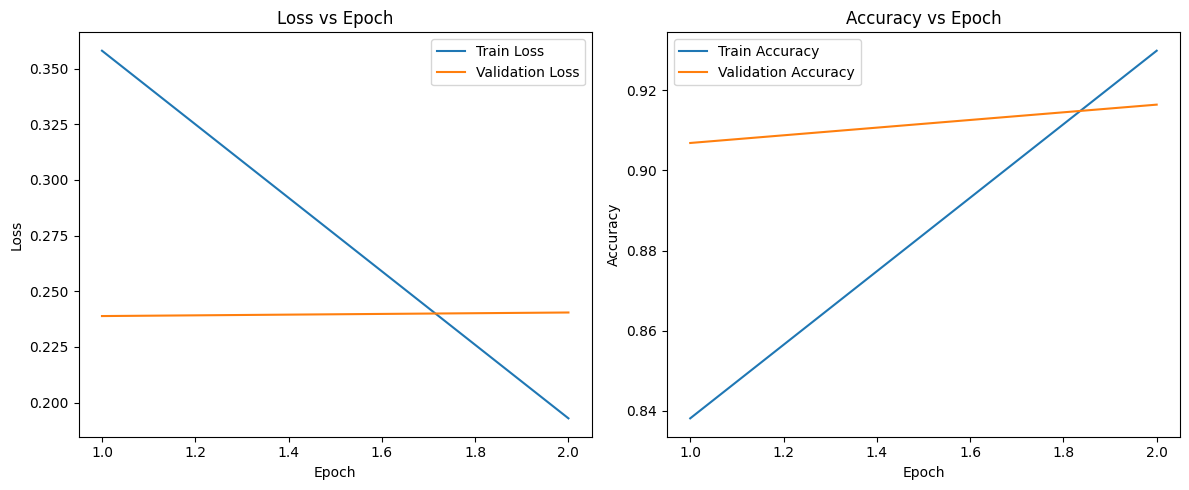

In [10]:
trainer.train()

In [11]:
trainer.test()

Evaluating:   0%|          | 0/938 [00:00<?, ?it/s]

Test loss: 0.2573, Test accuracy: 0.9137


([np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64